In [1]:
import json
from opti.Generation import op_lst_to_dict, Generation
from os import listdir, getcwd
from os.path import isfile, join
import re
mypath = "jsons_new\\"
mypath_pop = mypath+"lsts\\"

# mypath = "jsons_copy_mad\\"

# mypath = "jsons_copy_lessmad\\"

allfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
allfiles_pop = [f for f in listdir(mypath_pop) if isfile(join(mypath_pop, f))]

# slst = [op.to_str() for op in g.pop.values()]
# with open(f"jsons\\gener{g.num_g}.json", 'w') as openfile:
#     json.dump(slst, openfile)
# with open(f"jsons\\gener{g.num_g}.json", 'r') as openfile:
#     data = json.load(openfile)
# d = op_lst_to_dict([OptiPerson.from_string(s, cc) for s in slst])


In [2]:
from ChrContrBall import ChrContrBall
from opti.OptiPerson import OptiPerson
from functional import seq


cc = ChrContrBall()

tp_lst = []
for fpath in allfiles:
    with open(mypath+fpath, 'r') as openfile:
        data = json.load(openfile)
    op = OptiPerson.from_string(data, cc)
    fit = op.best_fitness
    tp_lst.append((fit, op))
    
for fpath in ['tmp_save2.json', 'tmp_save3.json', 'tmp_save4.json']:
    with open(mypath_pop+fpath, 'r') as openfile:
        data = json.load(openfile)
    for d in data:
        op = OptiPerson.from_string(d, cc)
        fit = op.best_fitness
        tp_lst.append((fit, op))
tp_lst = seq(tp_lst).distinct_by(lambda tp: tp[0]).sorted().to_list()
tp_lst;

In [3]:
import sys
sys.path.append("..\\PB11")

from MegaTask import wchr_to_solver

fit_solvers = seq(tp_lst).map(lambda tp: (tp[0], wchr_to_solver(tp[1].get_best()))).to_list()

done + sleep -9990 9.094947017729282e-13 2000.0


In [4]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 


import matplotlib.pyplot as plt
import numpy as np
from math import pi
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9,4) 

class Tube(object):
    def __init__(self, xs, ds):
        self.d = interpolate.interp1d(xs, ds, bounds_error=False, fill_value=(ds[0], ds[-1]))
        dd = np.array(ds, dtype=np.float64)
        ss = dd ** 2 * pi * 0.25
        self.s = interpolate.interp1d(xs, ss, bounds_error=False, fill_value=(ss[0], ss[-1]))
        self.xs = xs
        self.ds = ds

        # Something new
        def ConeW(d1, d2, h):
            return pi * h * (d1 * d1 + d1 * d2 + d2 * d2) / 12

        xss = [xs[0] - 0.1] + [x for x in xs] + [xs[-1] + 0.1]
        dss = [ds[0]] + [d for d in ds] + [ds[-1]]

        ws = [0]
        for x1, x2, d1, d2 in zip(xss, xss[1:], dss, dss[1:]):
            ws.append(ConeW(d1, d2, x2 - x1) + ws[-1])

        self.w = interpolate.interp1d(xss, ws, bounds_error=False, fill_value="extrapolate")
        self.w_reverse = interpolate.interp1d(ws, xss, bounds_error=False, fill_value="extrapolate")
    
    def __repr__(self):
        return f'Tube(xs={self.xs}, ds={self.ds})'

    def get_stuff(self, xs):
        """
        return (ds)
        """
        x = np.array(xs, dtype=np.float64)

        x_right = np.roll(x, -1)

        dx = x_right - x

        s_l = self.s(x)
        s_r = self.s(x_right)

        ds = (s_r - s_l) / dx
        return ds[:-1]

    def get_W(self, xs):
        """
        ????????? ?????? ?????
        :param xs:
        :return:
        """
        x = np.array(xs, dtype=np.float64)

        x_right = np.roll(x, -1)

        dx = x_right - x

        s_l = self.s(x)
        s_r = self.s(x_right)

        W = (s_r + s_l + np.sqrt(s_l * s_r)) * dx / 3
        return W[:-1]

    def get_S(self, xs):
        """
        ????????? ???????? ? ?????
        :param xs:
        :return:
        """
        x = np.array(xs, dtype=np.float64)
        s = self.s(x)
        return s

    def get_W_between(self, x1, x2):
        return self.w(x2) - self.w(x1)

    def get_x2(self, x1, w):
        w1 = self.w(x1)
        return self.w_reverse(w1 + w)
    
def plot_muzzle(solver, saveFigName = None):
    ax = plt.axes()
    
    geom = solver['geom']
    bord = solver['borders']
    
    geom.insert(0, (0, geom[0][1]))
    if bord[-1]['x'] > geom[-1][0]:
        geom.append((1.1 * bord[-1]['x'], geom[-1][1]))
    buf = list(zip(*(geom)))
    xs, ys = buf[0], buf[1]
    ds = buf[1]
    
    y = interpolate.interp1d(buf[0], buf[1], bounds_error=False, fill_value=(buf[1][0], buf[1][-1]))
    
    def ConeW(d1, d2, h):
        return pi * h * (d1 * d1 + d1 * d2 + d2 * d2) / 12

    xss = [xs[0] - 0.1] + [x for x in xs] + [xs[-1] + 0.1]
    dss = [ds[0]] + [d for d in ds] + [ds[-1]]

    ws = [0]
    for x1, x2, d1, d2 in zip(xss, xss[1:], dss, dss[1:]):
        ws.append(ConeW(d1, d2, x2 - x1) + ws[-1])

    w = interpolate.interp1d(xss, ws, bounds_error=False, fill_value="extrapolate")
    
    def get_W_between(x1, x2):
        return w(x2) - w(x1)
    
    xx = list(xs)+[xs[-1]+0.5]
    yy = list(ys)+[ys[-1]]
    line = plt.Line2D(xx, yy, label='ствол', color='k', linewidth=3)
    ax.add_line(line)
    
    line_axis = plt.Line2D([xx[0], xx[-1]], [0, 0], linestyle='-.', linewidth=1, color='k')
    ax.add_line(line_axis)
    
    l1,l2,l3 = 0,0,0
    for i in range(len(bord)):
        line = plt.Line2D([bord[i]['x'], bord[i]['x']], [0, y(bord[i]['x'])], marker='.', linewidth=2, color='k')
        ax.add_line(line)
        if i != (len(bord) - 1):
            x1 = np.linspace(bord[i]['x'], bord[i+1]['x'], 500)
            y1 = y(x1)
            x1 = np.insert(x1, 0, x1[0])
            x1 = np.append(x1, x1[-1])

            y1 = np.insert(y1, 0, 0)
            y1 = np.append(y1, 0)
            
            if solver['grids'][i]['type'] == 'gas':
                l1 += 1
                col = 'silver'
                if l1 == 1:
                    lab = 'Газ'
                else:
                    lab = ''
                ax.annotate('p='+str(round(solver['grids'][i]['init_const']['p']/101325))
                            , xy=(np.mean(x1), np.mean(y1)*0.3)
                            , xytext=(np.mean(x1), max(y1)*1.5),
                            arrowprops=dict(facecolor='black', width=0.01, headwidth=3, headlength=5))
            elif solver['grids'][i]['type'] == 'powder':
                l2 += 1
                col = 'sienna'
                if l2 == 1:
                    lab = 'Порох'
                else:
                    lab = ''
                sign = -1 if i %2 ==0 else 1.5
                ax.annotate('$\omega$='+str(round(solver['grids'][i]['init_const']['ro']*get_W_between(x1[0],x1[-1])*1000, 1))
                            , xy=(np.mean(x1), np.mean(y1)*0.3)
                            , xytext=(np.mean(x1), sign*max(y1)),
                            arrowprops=dict(facecolor='black', width=0.01, headwidth=3, headlength=5))
            elif solver['grids'][i]['type'] == 'piston':
                l3 += 1
                col = 'cornflowerblue'
                if l3 == 1:
                    lab = 'Поршень'
                else:
                    lab = ''

            plt.fill(x1, y1, color=col, label=lab)
            

            
    ax.legend(loc='upper center', shadow=True, ncol=4)
    plt.xlim((xx[0]-0.1*(xx[-1]-xx[0]), xx[-1]+0.1*(xx[-1]-xx[0])))
    plt.ylim((-2*max(ys), 3*max(ys)))
    if saveFigName:
        plt.savefig(saveFigName, bbox_inches='tight',dpi=300)
        return
#     plt.grid(True)
    plt.show()

In [5]:
from ipywidgets import interact, interactive, fixed
import ipywidgets

sel_var = fit_solvers[-1][1]

@interact(ind=ipywidgets.IntSlider(min=0,max=len(fit_solvers)-1,step=1, value=len(fit_solvers)-1))
def plotMe(ind):
    global sel_var
    sel_var = fit_solvers[ind][1]
    plt.title(f"fit_func = {fit_solvers[ind][0]}")
    plot_muzzle(fit_solvers[ind][1])

interactive(children=(IntSlider(value=3198, description='ind', max=3198), Output()), _dom_classes=('widget-int…

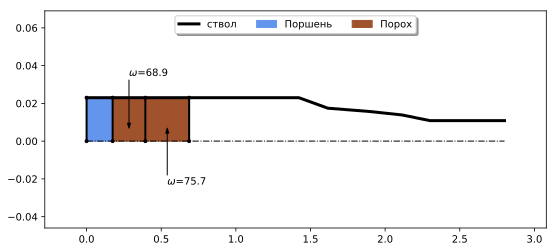

In [6]:
plot_muzzle(sel_var, '3987.png')


In [7]:
sel_var

{'borders': [{'m': 10000, 'p_f': 10000000000.0, 'x': 0, 'V': 0},
  {'m': 0.11564879391352431,
   'p_f': 4516847.128628838,
   'x': 0.17444290415391173,
   'V': 0},
  {'m': 0.07877005377939676,
   'p_f': 4627755.758919498,
   'x': 0.393711465922265,
   'V': 0},
  {'m': 0.023, 'p_f': 4130460.0900932783, 'x': 0.6870078214890485, 'V': 0}],
 'grids': [{'name': 'piston',
   'n_cells': 70,
   'consts': {'covolume': 0,
    'gamma': 1.63098,
    'c0': 2380,
    'ro0': 919.03,
    'sigmas': 25200000.0,
    'k0': 0.054,
    'b1': 0.027,
    'b2': 0.00675,
    'mu': 0.001,
    'taus': 1000000.0},
   'type': 'piston'},
  {'name': 'powder',
   'n_cells': 44,
   'consts': {'covolume': 0,
    'R': 287,
    'gamma': 1.228,
    'param_powder': {'I_k': 0.32,
     'T_1': 3006.0,
     'Z_k': 1.488,
     'alpha_k': 1.008,
     'etta': 0.228,
     'f': 1.027,
     'k_1': 0.811,
     'k_2': 0.505,
     'k_f': 0.0003,
     'k_l': 0.0016,
     'lambda_1': 0.081,
     'lambda_2': -1.024,
     'name': '4\\7',
   

In [8]:
tp_lst[90][1].get_best()

{'fitness': 1118.92219288,
 'name': 'Стогордет',
 'chromo': {'l_0': 1.1704992107646017,
  'l_1': 0.25558050275135813,
  'l_2': 0.3840826241469054,
  'l_3': 0.14797005712245007,
  'l_4': 0.3993181656148072,
  'd_0': 0.023,
  'd_1': 0.014742232744894394,
  'd_2': 0.014742232744894394,
  'd_3': 0.014742232744894394,
  'd_4': 0.013973590309216351,
  'struct': ['powder', 'powder', 'piston'],
  'struct_chromos': [{'omega_powder': 0.013606294855633881,
    't_powder': 0.0019479455087553037,
    'powder_type': '4\\1 фл',
    'delta_powder': 652.3876751356001,
    'mass_bord_left': 0.2401988887807555,
    'mass_bord_right': 0.272249707593259,
    'p_bord_force_left': 1817970.9604818458,
    'p_bord_force_right': 5171916.826221272},
   {'omega_powder': 0.032296264045266344,
    't_powder': 0.001038682983008839,
    'powder_type': '5\\1 х-10',
    'delta_powder': 663.8518618514552,
    'mass_bord_left': 0.272249707593259,
    'mass_bord_right': 0.1356287051001297,
    'p_bord_force_left': 5171916

In [9]:
my_best = {'d_0': 0.023,
  'd_1': 0.014742232744894394,
  'd_2': 0.014742232744894394,
  'd_3': 0.014742232744894394,
  'd_4': 0.013973590309216351,
  'l_0': 1.1704992107646017,
  'l_1': 0.25558050275135813,
  'l_2': 0.3840826241469054,
  'l_3': 0.14797005712245007,
  'l_4': 0.3993181656148072,
  'struct': ['powder', 'piston'],
  'struct_chromos': [{'delta_powder': 652.3876751356001,
    'mass_bord_left': 0.2401988887807555,
    'mass_bord_right': 0.0864268379297278,
    'omega_powder': 0.04360629485563388,
    'p_bord_force_left': 1817970.9604818458,
    'p_bord_force_right': 3869473.262000721,
    'powder_type': '4\\7',
    't_powder': 1e-06},
   {'mass_bord_left': 0.0864268379297278,
    'mass_bord_right': 0.03546250303802332,
    'omega_piston': 0.04579144123124086,
    'p_bord_force_left': 3869473.262000721,
    'p_bord_force_right': 9703725.233581023}]}
cc.chromo_barber(my_best)
op = OptiPerson(cc, my_best, name='Мойо')

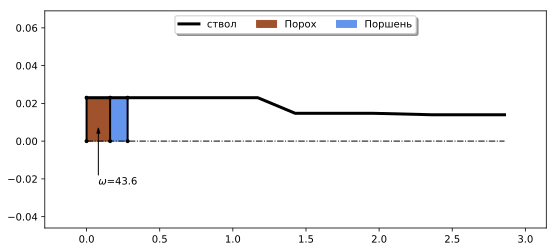

In [10]:
my_solv = wchr_to_solver(op.get_last())
plot_muzzle(my_solv, '1249.png')

In [11]:
my_solv

{'borders': [{'m': 10000, 'p_f': 10000000000.0, 'x': 0, 'V': 0},
  {'m': 0.0864268379297278,
   'p_f': 3869473.262000721,
   'x': 0.16087845463860284,
   'V': 0},
  {'m': 0.023, 'p_f': 9703725.233581023, 'x': 0.28054675671436935, 'V': 0}],
 'grids': [{'name': 'powder',
   'n_cells': 33,
   'consts': {'covolume': 0,
    'R': 287,
    'gamma': 1.228,
    'param_powder': {'I_k': 0.32,
     'T_1': 3006.0,
     'Z_k': 1.488,
     'alpha_k': 1.008,
     'etta': 0.228,
     'f': 1.027,
     'k_1': 0.811,
     'k_2': 0.505,
     'k_f': 0.0003,
     'k_l': 0.0016,
     'lambda_1': 0.081,
     'lambda_2': -1.024,
     'name': '4\\7',
     'ro': 1.6},
    'nu': 1},
   'type': 'powder',
   'init_const': {'ro': 652.3876751356001, 't_init': 1e-06}},
  {'name': 'piston',
   'n_cells': 48,
   'consts': {'covolume': 0,
    'gamma': 1.63098,
    'c0': 2380,
    'ro0': 919.03,
    'sigmas': 25200000.0,
    'k0': 0.054,
    'b1': 0.027,
    'b2': 0.00675,
    'mu': 0.001,
    'taus': 1000000.0},
   'type'

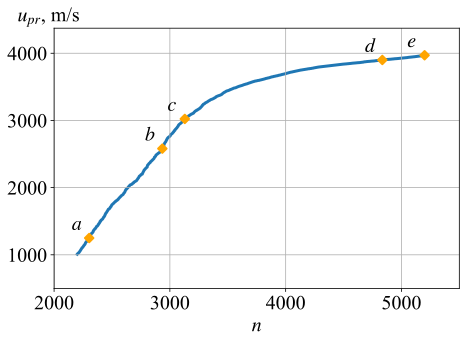

In [80]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (3.248031*8.25/7.5*2*16.5/16.27*16.5/16.43, 1.9685*5/5.585*2*10/9.65*10/9.90*6.5/5) 
plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['figure.dpi'] = 300
# ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'font.size': 20})
# del mpl.font_manager.weight_dict['roman']
mpl.font_manager._rebuild()

# plt.subplot()

lst4dr = seq(tp_lst[:-150]).filter(lambda tp: tp[0] >=1000).to_list()
xs = [i+2200 for i in range(len(lst4dr))]
ys = seq(lst4dr).map(lambda tp: tp[0]).to_list()
fig, ax = plt.subplots()
plt.plot(xs,ys, linewidth=1.5*2,zorder=1)
plt.ylim([500,1.1*max(ys)])
plt.xlim([2000,5500])
ax.xaxis.set_label_text('$n$')
plt.figtext(0.055, 0.9, '$u_{pr}$, m/s')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

def plot_p(vel, text):
    i = seq(enumerate(lst4dr)).filter(lambda tp2: tp2[1][0]>=vel).first()[0]
    plt.scatter(xs[i], ys[i], marker='D', c='orange', linewidths=2,zorder=2)
    plt.annotate(text, (xs[i]-150, ys[i]+120), fontsize=20)

plot_p(1249, '$a$')
plot_p(2580 , '$b$')
plot_p(3022 , '$c$')
plot_p(3900 , '$d$')
plot_p(3970 , '$e$')

plt.grid()

plt.savefig('6.png', bbox_inches='tight',dpi=300, format='png', pad_inches=0.1)

In [81]:
# mpl.rcParams['savefig.bbox'] = (3.149606,1.9685)

In [55]:
my_abcde = []
my_best = {'d_0': 0.023,
  'd_1': 0.014742232744894394,
  'd_2': 0.014742232744894394,
  'd_3': 0.014742232744894394,
  'd_4': 0.013973590309216351,
  'l_0': 1.1704992107646017,
  'l_1': 0.25558050275135813,
  'l_2': 0.3840826241469054,
  'l_3': 0.14797005712245007,
  'l_4': 0.3993181656148072,
  'struct': ['powder', 'piston'],
  'struct_chromos': [{'delta_powder': 652.3876751356001,
    'mass_bord_left': 0.2401988887807555,
    'mass_bord_right': 0.0864268379297278,
    'omega_powder': 0.04360629485563388,
    'p_bord_force_left': 1817970.9604818458,
    'p_bord_force_right': 3869473.262000721,
    'powder_type': '4\\7',
    't_powder': 0},
   {'mass_bord_left': 0.0864268379297278,
    'mass_bord_right': 0.03546250303802332,
    'omega_piston': 0.04579144123124086,
    'p_bord_force_left': 3869473.262000721,
    'p_bord_force_right': 9703725.233581023}]}
cc.chromo_barber(my_best)
op = OptiPerson(cc, my_best, name='Мойо')
my_abcde.append(wchr_to_solver(op.get_last()))

In [56]:
my_best = {'d_0': 0.023,
  'd_1': 0.014293896653096315,
  'd_2': 0.013365512846979032,
  'd_3': 0.012396279886267791,
  'd_4': 0.012396279886267791,
  'l_0': 1.436688653282441,
  'l_1': 0.28988752387565764,
  'l_2': 0.1955663334705792,
  'l_3': 0.08188454308795351,
  'l_4': 0.16571081753554584,
  'struct': ['powder', 'gas'],
  'struct_chromos': [{'delta_powder': 764.7577921906336,
    'mass_bord_left': 0.19410139750377026,
    'mass_bord_right': 0.1809522708546089,
    'omega_powder': 0.05201717188808344,
    'p_bord_force_left': 4693649.363263284,
    'p_bord_force_right': 5261060.351248696,
    'powder_type': '7\\1',
    't_powder': 0.00},
   {'l_gas': 1.1415162345449017,
    'mass_bord_left': 0.1809522708546089,
    'mass_bord_right': 0.20319048138246956,
    'p_bord_force_left': 5261060.351248696,
    'p_bord_force_right': 8795339.174276019,
    'p_gas': 29382506.356983207,
    'type_gas': 'He'}]}
cc.chromo_barber(my_best)
op = OptiPerson(cc, my_best, name='Мойо')
my_abcde.append(wchr_to_solver(op.get_last()))

In [57]:
my_best = {'d_0': 0.023,
  'd_1': 0.021472233962169077,
  'd_2': 0.015529806345839791,
  'd_3': 0.014293630601759477,
  'd_4': 0.011892201133181785,
  'l_0': 1.5677863615295853,
  'l_1': 0.31797509650436595,
  'l_2': 0.4673304036586768,
  'l_3': 0.4832121632349122,
  'l_4': 0.4721431883016241,
  'struct': ['gas', 'piston', 'powder', 'powder'],
  'struct_chromos': [{'l_gas': 1.446561149965973,
    'mass_bord_left': 0.17302856088933066,
    'mass_bord_right': 0.29328126592937304,
    'p_bord_force_left': 9531878.68423476,
    'p_bord_force_right': 6200542.339077928,
    'p_gas': 2694293.8006500895,
    'type_gas': 'CO_2'},
   {'mass_bord_left': 0.29328126592937304,
    'mass_bord_right': 0.09549866514673461,
    'omega_piston': 0.08184667544574999,
    'p_bord_force_left': 6200542.339077928,
    'p_bord_force_right': 7872215.300410532},
   {'delta_powder': 813.9169183625717,
    'mass_bord_left': 0.09549866514673461,
    'mass_bord_right': 0.14240338876633438,
    'omega_powder': 0.05658381255493401,
    'p_bord_force_left': 7872215.300410532,
    'p_bord_force_right': 4825916.709305087,
    'powder_type': '5\\1 х-10',
    't_powder': 0.0017981419946588959},
   {'delta_powder': 806.0026457006754,
    'mass_bord_left': 0.14240338876633438,
    'mass_bord_right': 0.19471368502885056,
    'omega_powder': 0.02559801392230332,
    'p_bord_force_left': 4825916.709305087,
    'p_bord_force_right': 3400658.9804418925,
    'powder_type': '4\\7 св',
    't_powder': 0.00186816405363142}]}

# my_best = {'d_0': 0.023,
#   'd_1': 0.021472233962169077,
#   'd_2': 0.015529806345839791,
#   'd_3': 0.014293630601759477,
#   'd_4': 0.011892201133181785,
#   'l_0': 1.5677863615295853,
#   'l_1': 0.31797509650436595,
#   'l_2': 0.4673304036586768,
#   'l_3': 0.4832121632349122,
#   'l_4': 0.4721431883016241,
#   'struct': ['gas', 'powder', 'powder'],
#   'struct_chromos': [{'l_gas': 0.446561149965973,
#     'mass_bord_left': 0.17302856088933066,
#     'mass_bord_right': 0.19549866514673461,
#     'p_bord_force_left': 9531878.68423476,
#     'p_bord_force_right': 6200542.339077928,
#     'p_gas': 7694293.8006500895,
#     'type_gas': 'He'},
#    {'delta_powder': 813.9169183625717,
#     'mass_bord_left': 0.19549866514673461,
#     'mass_bord_right': 0.14240338876633438,
#     'omega_powder': 0.05658381255493401,
#     'p_bord_force_left': 7872215.300410532,
#     'p_bord_force_right': 4825916.709305087,
#     'powder_type': '4\\7',
#     't_powder': 0.0},
#    {'delta_powder': 806.0026457006754,
#     'mass_bord_left': 0.14240338876633438,
#     'mass_bord_right': 0.19471368502885056,
#     'omega_powder': 0.02559801392230332,
#     'p_bord_force_left': 4825916.709305087,
#     'p_bord_force_right': 3400658.9804418925,
#     'powder_type': '4\\7',
#     't_powder': 0.0001}]}
cc.chromo_barber(my_best)
op = OptiPerson(cc, my_best, name='Мойо')
my_abcde.append(wchr_to_solver(op.get_last()))


In [58]:
my_best = {'d_0': 0.023,
  'd_1': 0.020051911767386275,
  'd_2': 0.018440868426476742,
  'd_3': 0.012523389538729338,
  'd_4': 0.010415630375048335,
  'l_0': 1.1342540897474174,
  'l_1': 0.30243670144339935,
  'l_2': 0.23074883105824193,
  'l_3': 0.24580697538192825,
  'l_4': 0.16321581396283766,
  'struct': ['powder', 'piston', 'powder'],
  'struct_chromos': [{'delta_powder': 696.7741024257499,
    'mass_bord_left': 0.22126981369900348,
    'mass_bord_right': 0.10035998602876905,
    'omega_powder': 0.03955292191827727,
    'p_bord_force_left': 7340811.37939667,
    'p_bord_force_right': 6292377.379578602,
    'powder_type': '11\\7',
    't_powder': 0.0011689653385888632},
   {'mass_bord_left': 0.10035998602876905,
    'mass_bord_right': 0.1508632390666016,
    'omega_piston': 0.055719250078304985,
    'p_bord_force_left': 6292377.379578602,
    'p_bord_force_right': 5523792.95991849},
   {'delta_powder': 755.6983581884863,
    'mass_bord_left': 0.1508632390666016,
    'mass_bord_right': 0.2156885817829277,
    'omega_powder': 0.09395211716775483,
    'p_bord_force_left': 5523792.95991849,
    'p_bord_force_right': 4751520.508163942,
    'powder_type': '5\\1',
    't_powder': 0.001089993327164366}]}
# my_best = {'d_0': 0.023,
#   'd_1': 0.020051911767386275,
#   'd_2': 0.018440868426476742,
#   'd_3': 0.012523389538729338,
#   'd_4': 0.010415630375048335,
#   'l_0': 1.1342540897474174,
#   'l_1': 0.30243670144339935,
#   'l_2': 0.23074883105824193,
#   'l_3': 0.24580697538192825,
#   'l_4': 0.16321581396283766,
#   'struct': ['powder', 'powder'],
#   'struct_chromos': [{'delta_powder': 696.7741024257499,
#     'mass_bord_left': 0.22126981369900348,
#     'mass_bord_right': 0.1035998602876905,
#     'omega_powder': 0.03955292191827727,
#     'p_bord_force_left': 7340811.37939667,
#     'p_bord_force_right': 60292377.379578602,
#     'powder_type': '4\\7',
#     't_powder': 0.0},
#    {'delta_powder': 755.6983581884863,
#     'mass_bord_left': 0.1035998602876905,
#     'mass_bord_right': 0.2156885817829277,
#     'omega_powder': 0.09395211716775483,
#     'p_bord_force_left': 60292377.379578602,
#     'p_bord_force_right': 4751520.508163942,
#     'powder_type': '4\\7',
#     't_powder': 0.0}]}
cc.chromo_barber(my_best)
op = OptiPerson(cc, my_best, name='Мойо')
my_abcde.append(wchr_to_solver(op.get_last()))

In [59]:
my_best = {'d_0': 0.023,
  'd_1': 0.017432962046584028,
  'd_2': 0.012736461410362138,
  'd_3': 0.010871293782363995,
  'd_4': 0.01,
  'l_0': 2.0,
  'l_1': 0.5,
  'l_2': 0.5,
  'l_3': 0.5,
  'l_4': 0.5,
  'struct': ['powder', 'powder', 'piston', 'gas'],
  'struct_chromos': [{'delta_powder': 700,
    'mass_bord_left': 0.11564879391352431,
    'mass_bord_right': 0.10782439695676216,
    'omega_powder': 0.07,
    'p_bord_force_left': 4516847.128628838,
    'p_bord_force_right': 5072301.443774167,
    'powder_type': '4\\7',
    't_powder': 0.0},
   {'delta_powder': 600,
    'mass_bord_left': 0.10782439695676216,
    'mass_bord_right': 0.17307340949196603,
    'omega_powder': 0.04,
    'p_bord_force_left': 5072301.443774167,
    'p_bord_force_right': 4803015.730228667,
    'powder_type': '4\\7',
    't_powder': 0.001},
   {'mass_bord_left': 0.17307340949196603,
    'mass_bord_right': 0.1071657474089858,
    'omega_piston': 0.1,
    'p_bord_force_left': 4803015.730228667,
    'p_bord_force_right': 4699654.659919793},
   {'l_gas': 2,
    'mass_bord_left': 0.1071657474089858,
    'mass_bord_right': 0.10902363944380589,
    'p_bord_force_left': 4699654.659919793,
    'p_bord_force_right': 9935754.468408778,
    'p_gas': 7000000.763701452,
    'type_gas': 'He'}]}

# my_best = {'d_0': 0.023,
#   'd_1': 0.017432962046584028,
#   'd_2': 0.012736461410362138,
#   'd_3': 0.010871293782363995,
#   'd_4': 0.01,
#   'l_0': 2.0,
#   'l_1': 0.5,
#   'l_2': 0.5,
#   'l_3': 0.5,
#   'l_4': 0.5,
#   'struct': ['powder', 'powder', 'gas'],
#   'struct_chromos': [{'delta_powder': 700,
#     'mass_bord_left': 0.11564879391352431,
#     'mass_bord_right': 0.10782439695676216,
#     'omega_powder': 0.07,
#     'p_bord_force_left': 4516847.128628838,
#     'p_bord_force_right': 5072301.443774167,
#     'powder_type': '4\\7',
#     't_powder': 0.0},
#    {'delta_powder': 600,
#     'mass_bord_left': 0.10782439695676216,
#     'mass_bord_right': 0.2071657474089858,
#     'omega_powder': 0.04,
#     'p_bord_force_left': 5072301.443774167,
#     'p_bord_force_right': 4803015.730228667,
#     'powder_type': '4\\7',
#     't_powder': 0.0},
#    {'l_gas': 2,
#     'mass_bord_left': 0.2071657474089858,
#     'mass_bord_right': 0.10902363944380589,
#     'p_bord_force_left': 4699654.659919793,
#     'p_bord_force_right': 9935754.468408778,
#     'p_gas': 7000000.763701452,
#     'type_gas': 'He'}]}
cc.chromo_barber(my_best)
op = OptiPerson(cc, my_best, name='Мойо')
my_abcde.append(wchr_to_solver(op.get_last()))

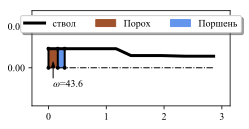

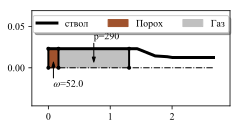

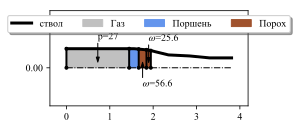

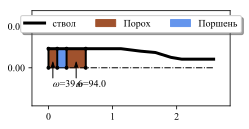

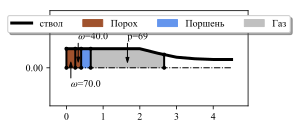

In [60]:
for m in my_abcde:
    plot_muzzle(m)

In [129]:
from matplotlib.patches import Patch
mpl.rcParams['figure.figsize'] = (3.248031*8.25/7.5*2*16.5/16.27*16.5/16.43*2, 1.9685*5/5.585*2*10/9.65*10/9.90*6.5/5) 
plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['figure.dpi'] = 300
# ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'font.size': 20})
# del mpl.font_manager.weight_dict['roman']
mpl.font_manager._rebuild()
def plot_muzzles(solvers, texts, saveFigName = None):
    ytks = []
    yytks = []
#     plt.figure(1)
    ax = plt.subplot(121)
    for i, tp in enumerate(reversed(list(zip(solvers, texts)))):
        h00 = i*0.04
#         ax = plt.axes()
        
        solver, text = tp

        geom = solver['geom']
        bord = solver['borders']

        geom.insert(0, (0, geom[0][1]))
        if bord[-1]['x'] > geom[-1][0]:
            geom.append((1.1 * bord[-1]['x'], geom[-1][1]))
        buf = list(zip(*(geom)))
        xs, ys = buf[0], buf[1]
        ds = buf[1]

        y = interpolate.interp1d(buf[0], buf[1], bounds_error=False, fill_value=(buf[1][0], buf[1][-1]))

        def ConeW(d1, d2, h):
            return pi * h * (d1 * d1 + d1 * d2 + d2 * d2) / 12

        xss = [xs[0] - 0.1] + [x for x in xs] + [xs[-1] + 0.1]
        dss = [ds[0]] + [d for d in ds] + [ds[-1]]

        ws = [0]
        for x1, x2, d1, d2 in zip(xss, xss[1:], dss, dss[1:]):
            ws.append(ConeW(d1, d2, x2 - x1) + ws[-1])

        w = interpolate.interp1d(xss, ws, bounds_error=False, fill_value="extrapolate")

        def get_W_between(x1, x2):
            return w(x2) - w(x1)

        xx = np.array(list(xs)+[xs[-1]+0.5])
        yy = np.array(list(ys)+[ys[-1]])+h00
        line = plt.Line2D(xx, yy, color='k', linewidth=2)
        ax.add_line(line)
        
        yytks.append(h00)
        yytks.append(h00+yy[0])
        ytks.append(0)
        ytks.append(yy[0]-h00)

        line_axis = plt.Line2D([xx[0], xx[-1]], [h00, h00], linestyle='-.', linewidth=1, color='k')
        ax.add_line(line_axis)

        l1,l2,l3 = 0,0,0
        for i in range(len(bord)):
            line = plt.Line2D([bord[i]['x'], bord[i]['x']], [0+h00, y(bord[i]['x'])+h00], marker='.', linewidth=2, color='k')
            ax.add_line(line)
            if i != (len(bord) - 1):
                x1 = np.linspace(bord[i]['x'], bord[i+1]['x'], 500)
                y1 = y(x1)
                x1 = np.insert(x1, 0, x1[0])
                x1 = np.append(x1, x1[-1])

                y1 = np.insert(y1, 0, 0)
                y1 = np.append(y1, 0)

                if solver['grids'][i]['type'] == 'gas':
                    l1 += 1
                    col = 'silver'
                    if l1 == 1:
                        lab = '1'
                    else:
                        lab = ''
#                     ax.annotate('p='+str(round(solver['grids'][i]['init_const']['p']/101325))
#                                 , xy=(np.mean(x1), np.mean(y1)*0.3+h00)
#                                 , xytext=(np.mean(x1), max(y1)*1.5+h00),
#                                 arrowprops=dict(facecolor='black', width=0.01, headwidth=3, headlength=5))
                elif solver['grids'][i]['type'] == 'powder':
                    l2 += 1
                    col = 'sienna'
                    if l2 == 1:
                        lab = '2'
                    else:
                        lab = ''
                    sign = 1.5
#                     ax.annotate('$\omega$='+str(round(solver['grids'][i]['init_const']['ro']*get_W_between(x1[0],x1[-1])*1000, 1))
#                                 , xy=(np.mean(x1), np.mean(y1)*0.3+h00)
#                                 , xytext=(np.mean(x1), sign*max(y1)+h00),
#                                 arrowprops=dict(facecolor='black', width=0.01, headwidth=3, headlength=5))
                elif solver['grids'][i]['type'] == 'piston':
                    l3 += 1
                    col = 'cornflowerblue'
                    if l3 == 1:
                        lab = '3'
                    else:
                        lab = ''

                plt.fill_between(x1, y1+h00, y2=h00, color=col, label=lab)

        plt.annotate(text, (-0.25, h00+0.007), fontsize=20)

#     ax.legend(loc='upper center', shadow=True, ncol=3)
    plt.xlim(-0.5)
    plt.ylim((-0.01, 0.25))
    plt.yticks([], [])
    legend_elements=[]
    legend_elements.append( Patch(facecolor='sienna', alpha=1, label=f'- 1'))
    legend_elements.append( Patch(facecolor='silver', alpha=1, label=f'- 2'))
    legend_elements.append( Patch(facecolor='cornflowerblue', alpha=1, label=f'- 3'))
    plt.legend(handles=legend_elements, loc='upper center', ncol=3 )
    plt.xlabel('$x$, m')
    
    


    ax = plt.subplot(122)

    lst4dr = seq(tp_lst[:-150]).filter(lambda tp: tp[0] >=1000).to_list()
    xs = [i+2200 for i in range(len(lst4dr))]
    ys = seq(lst4dr).map(lambda tp: tp[0]).to_list()

    plt.plot(xs,ys, linewidth=1.5*2,zorder=1)
    plt.ylim([500,1.1*max(ys)])
    plt.xlim([2000,5500])
    ax.xaxis.set_label_text('$n$')
    
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)

    def plot_p(vel, text):
        i = seq(enumerate(lst4dr)).filter(lambda tp2: tp2[1][0]>=vel).first()[0]
        plt.scatter(xs[i], ys[i], marker='D', c='orange', linewidths=2,zorder=2)
        plt.annotate(text, (xs[i]-150, ys[i]+120), fontsize=20)

    plot_p(1249, '$a$')
    plot_p(2580 , '$b$')
    plot_p(3022 , '$c$')
    plot_p(3900 , '$d$')
    plot_p(3970 , '$e$')
    plt.figtext(0.52, 0.9, '$u_{pr}$, m/s')
    plt.grid()
    
    
    
    
    if saveFigName:
        plt.savefig(saveFigName,bbox_inches='tight',dpi=300, format='png', pad_inches=0.1)
        return
# #     plt.grid(True)
    plt.show()

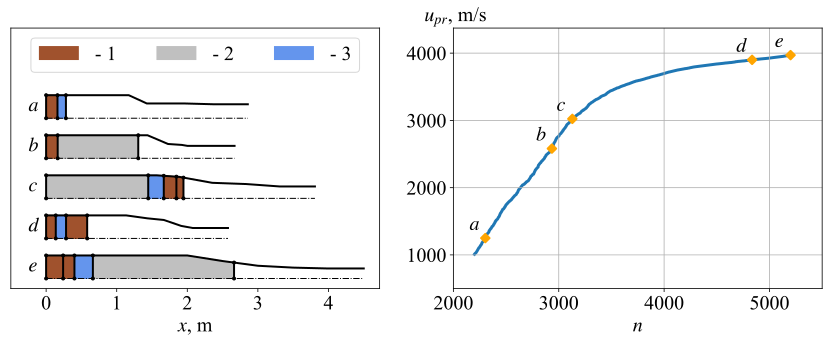

In [130]:
plot_muzzles(my_abcde, ['$a$', '$b$', '$c$', '$d$', '$e$'], 'gunz.png')

In [21]:
my_abcde[2]

{'borders': [{'m': 10000, 'p_f': 10000000000.0, 'x': 0, 'V': 0},
  {'m': 0.1954986651467346,
   'p_f': 7036378.81974423,
   'x': 0.446561149965973,
   'V': 0},
  {'m': 0.14240338876633438,
   'p_f': 4825916.709305087,
   'x': 0.6138883627753235,
   'V': 0},
  {'m': 0.023, 'p_f': 3400658.9804418925, 'x': 0.69032899144432, 'V': 0}],
 'grids': [{'name': 'gas',
   'n_cells': 90,
   'consts': {'covolume': 0.005925, 'R': 2078, 'gamma': 1.66},
   'type': 'gas',
   'init_const': {'p': 7694293.800650089, 'T': 300}},
  {'name': 'powder',
   'n_cells': 34,
   'consts': {'covolume': 0,
    'R': 287,
    'gamma': 1.228,
    'param_powder': {'I_k': 0.32,
     'T_1': 3006.0,
     'Z_k': 1.488,
     'alpha_k': 1.008,
     'etta': 0.228,
     'f': 1.027,
     'k_1': 0.811,
     'k_2': 0.505,
     'k_f': 0.0003,
     'k_l': 0.0016,
     'lambda_1': 0.081,
     'lambda_2': -1.024,
     'name': '4\\7',
     'ro': 1.6},
    'nu': 1},
   'type': 'powder',
   'init_const': {'ro': 813.9169183625717, 't_init':

In [22]:
from functional import seq
from OneVelocity.OvInit import ov_create_layer
from Pneumatics.PnInit import pn_create_layer
from ElasticPiston.ElPistInit import el_pist_create_layer

def get_lb(sol):
    geom = seq(sol['geom']).distinct().sorted().to_list()
    geom.append((geom[-1][0]+7, geom[-1][1]))
    tube = Tube(*list(zip(*geom)))
    borders = sol['borders']
    layers = []
    for grid, lborder, rborder in zip(sol['grids'], borders[:-1], borders[1:]):
        grid['xl'] = lborder['x']
        grid['xr'] = rborder['x']
        grid['vl'] = 0
        grid['vr'] = 0
        gtype = grid['type']
        create_f = ov_create_layer if gtype == 'powder' else \
                   pn_create_layer if gtype == 'gas' else \
                   el_pist_create_layer
        layers.append(create_f(grid, tube))
    return layers, borders

def newton(tau, f, m, v0, x0):
    a = f / m
    return x0 + v0 * tau + 0.5 * a * tau ** 2, v0 + a * tau

def euler_step(tau, layers, borders):
    tube = layers[0].tube
#     ps, ss, xs, vs = [], [], [], []
#     for lr in layers:
#         ps.append(lr.p[0])
#         ps.append(lr.p[-1])
#         xs.append(lr.x[0])
#         xs.append(lr.x[-1])
#         vs.append(lr.V[0])
#         vs.append(lr.V[-1])
#         s0, s1 = tube.get_S([lr.x[0], lr.x[-1]])
#         ss.append(s0)
#         ss.append(s1)
#     p_a = 101325.0
#     ps = [p_a] + ps + [p_a]
#     ss = [ss[0]] + ss + [ss[-1]]
#     xs = [xs[0]] + xs + [xs[-1]]
#     vs = [vs[0]] + vs + [vs[-1]]
#     args = []
#     tups = [tup for tup in zip(ps,ss,xs,vs)]
#     tups2 = [t1 + t2 + (b['m'], b['p_f']) for t1, t2, b in zip(tups[::2], tups[1::2], borders)]
#     for pl,sl,xl,vl, pr,sr,xr,vr, m, p_f in tups2:
#         v = vl
#         x = xl
#         if abs(pl - pr) > p_f or abs(v) > 1E-2:
#             force = pl*sl - pr*sr
#             x, v = newton(tau, force, m, v, x)
#         args.append((x,v))    
#     layers_new = []
#     for lr, xvl, xvr in zip(layers, args[::2], args[1::2]):
#         lrn = lr.euler_step_new(tau, *xvl, *xvr)
#         layers_new.append(lrn)
#     return layers_new
#     ]
    layers_new = []
    for i, lr in enumerate(layers):
        #left
        pl = layers[i-1].p[-1] if i != 0 else 101325.0
        pr = lr.p[0]
        xr = lr.x[0]
        xl = layers[i-1].x[-1] if i != 0 else xr
        sl,sr = tube.get_S([xl,xr])
        m = borders[i]['m']
        p_f = borders[i]['p_f']
        v = lr.V[0]
        x = xr
        if abs(pl - pr) > p_f or abs(v) > 1E-2:
            force = pl*sl - pr*sr
            x, v = newton(tau, force, m, v, x)        
        v1,x1 = v,x

        #right
        pl = lr.p[-1]
        pr = layers[i+1].p[0] if i < len(layers)-1 else 101325.0
        xl = lr.x[-1]
        xr = layers[i+1].x[0] if i < len(layers)-1 else xl
        sl,sr = tube.get_S([xl,xr])
        m = borders[i+1]['m']
        p_f = borders[i+1]['p_f']
        v = lr.V[-1]
        x = xl
        if abs(pl - pr) > p_f or abs(v) > 1E-2:
            force = pl*sl - pr*sr
            x, v = newton(tau, force, m, v, x)        
        v2,x2 = v,x
        
        lrn = lr.euler_step_new(tau,x1,v1, x2,v2)
        layers_new.append(lrn)
    return layers_new
        
    
print(get_lb(my_abcde[4]))
print(euler_step(1, *get_lb(my_abcde[4])))

([<OneVelocity.OvLayer.OvLayer object at 0x000002EE64E70DA0>, <OneVelocity.OvLayer.OvLayer object at 0x000002EE64E70A58>, <Pneumatics.PnLayer.PnLayer object at 0x000002EE679D67B8>], [{'m': 10000, 'p_f': 10000000000.0, 'x': 0, 'V': 0}, {'m': 0.10782439695676216, 'p_f': 5072301.443774167, 'x': 0.2406880046758344, 'V': 0}, {'m': 0.2071657474089858, 'p_f': 4751335.19507423, 'x': 0.4011466744597241, 'V': 0}, {'m': 0.023, 'p_f': 9935754.468408778, 'x': 2.4011466744597243, 'V': 0}])
[<OneVelocity.OvLayer.OvLayer object at 0x000002EE64E707B8>, <OneVelocity.OvLayer.OvLayer object at 0x000002EE6714EE80>, <Pneumatics.PnLayer.PnLayer object at 0x000002EE6714E6D8>]


In [23]:
(1,2) + (3,)

(1, 2, 3)

In [24]:
import time
from math import *
def calc_sol(solver, cour_num=0.33):
    layers, borders = get_lb(solver)
    start_time = time.time()
    Vmax = 0
    pmax = 0
    res = [layers]
    ind = 0
    l_max_mini = 7
    l_max = solver['geom'][-1][0] + l_max_mini
    while True:
        if l_max < layers[-1].x[-1]:
            break
        if (Vmax - layers[-1].V[-1]) > 20:
            break
        if layers[0].time >= 0.1:
            break
        if isnan(layers[0].time):
            res = res[:-1]
            break
        tau_arr = [l.time_step() for l in layers]
        tau = cour_num* min(tau_arr) 
        layers = euler_step(tau, layers, borders)
        if ind % 10 == 0:
            res.append(layers)
            if ind % 3000 == 0:
                print(layers[0].time, layers[-1].x_c[-1])
        ind += 1
        if layers[-1].V[-1] > Vmax:
            Vmax = layers[-1].V[-1]
        pmax = max([max(layer.p) for layer in layers])
    print(pmax, Vmax)
    return res

In [102]:
def convert_layers(res):
    ts = np.array([r[0].time for r in res])
    xss = []
    pss = []
    for r in res:
        xs = np.concatenate([l.x_c for l in r])
        ps = np.concatenate([l.p for l in r])
        xss.append(xs)
        pss.append(ps)
    return np.vstack(xss), np.vstack(pss)
        
xs, ps = convert_layers(res)

In [103]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(res)-1,step=1, value=0))
def plotMe(ind):
    plt.plot(xs[ind], ps[ind])
    plt.plot()

interactive(children=(IntSlider(value=0, description='ind', max=2177), Output()), _dom_classes=('widget-intera…

In [26]:
res = calc_sol(my_abcde[0])

3.4604529767187484e-07 0.2793002119010801
0.001038481938313328 0.2793002119010801
0.0020737799458256127 0.28176416960536765
0.0030634599783584578 0.36501927751488294
0.003936605049794282 0.7206072816895619
0.004736022945885502 1.2699151805874171
0.00664178820688772 3.694536496252509
0.010037681015140671 8.076017598485782
28497527.300501715 1296.0978641339386


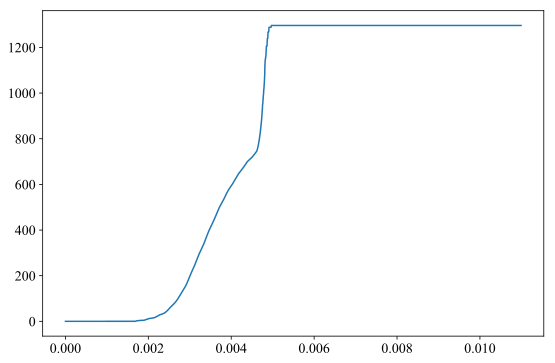

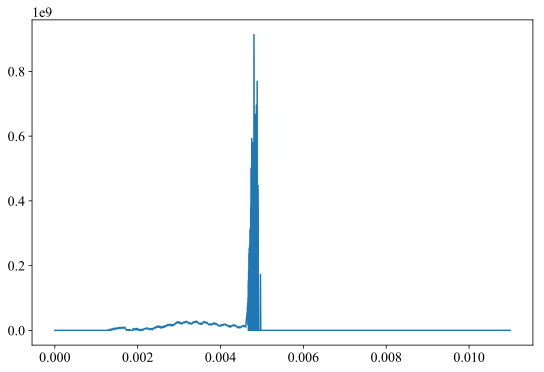

In [27]:
def print_res(res):
    ts = [r[-1].time for r in res]
    xs = [r[-1].x[-1] for r in res]
    vs = [r[-1].V[-1] for r in res]
    ps = [r[-1].p[-1] for r in res]
    plt.plot(ts, vs)
    plt.show()
    plt.plot(ts,ps)

print_res(res)

In [30]:
res1 = calc_sol(my_abcde[1])

1.2640490413009375e-06 1.3027350405095324
0.002891022026046918 2.4556324456537184
0.004236857334346843 4.253982844653864
53058796.8141488 2460.0770761730596


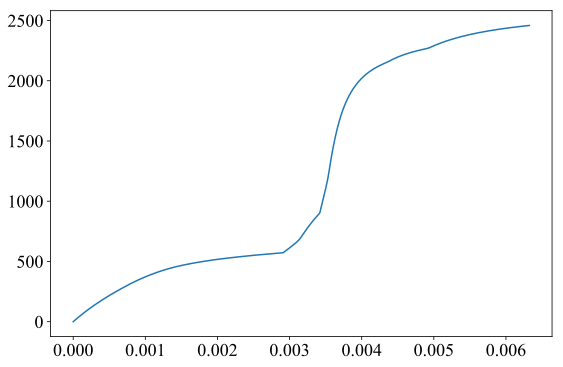

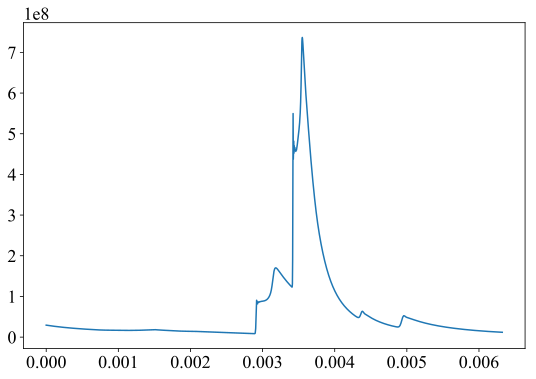

In [41]:
print_res(res1)

In [80]:
# my_abcde[2]['grids'][2]['init_const']['t_init']=0
# my_abcde[2]['grids'][3]['init_const']['t_init']=0
# my_abcde[2]['grids'][2]['n_cells'] =80
# my_abcde[2]['grids'][3]['n_cells'] = 50
# my_abcde[2]['grids'][0]['n_cells'] = 500
# my_abcde[2]['grids'][1]['n_cells'] = 190
for g in my_abcde[2]['grids']:
    g['n_cells'] *= 2
    print(f'{g["type"]} n = {g["n_cells"]}')

gas n = 580
powder n = 70
powder n = 34


1.8180632923339358e-06 0.6879402217984139
0.002879644670000313 1.3322827047319779
0.0030094866522781118 1.441870411266353
0.00303703883907159 1.4658527731250497
0.0030556504427024945 1.482192139635555
0.0030779164295943314 1.5018846869674416
0.003137314954847859 1.5551695401106052
0.0038279715432439293 2.238145393096878
0.00805093371403499 7.835832129051714
99221634.72499004 2052.410161820528


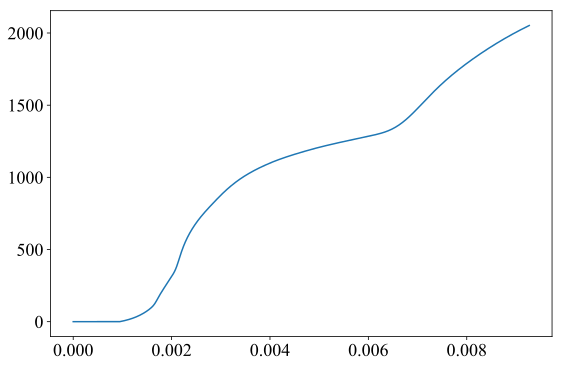

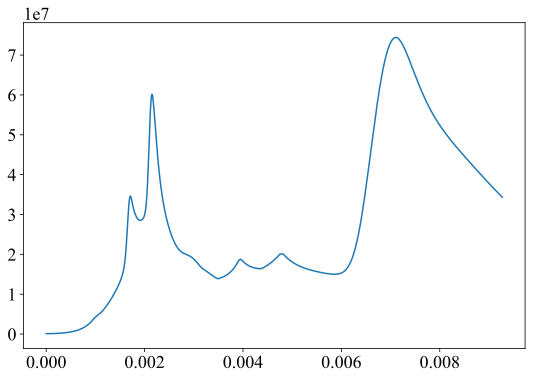

In [42]:
res2 = calc_sol(my_abcde[2], 0.4)
print_res(res2)

9.053648649010649e-05 0.43336988845511026
305676206.53532 3023.727925999151


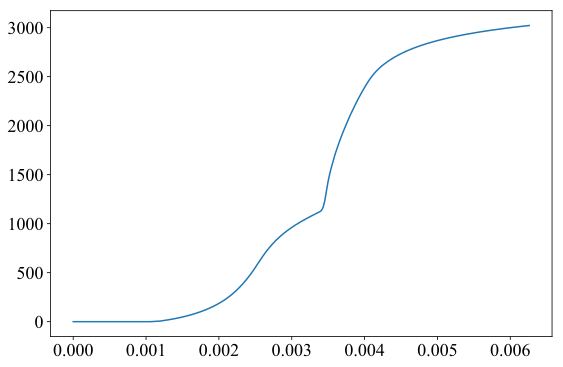

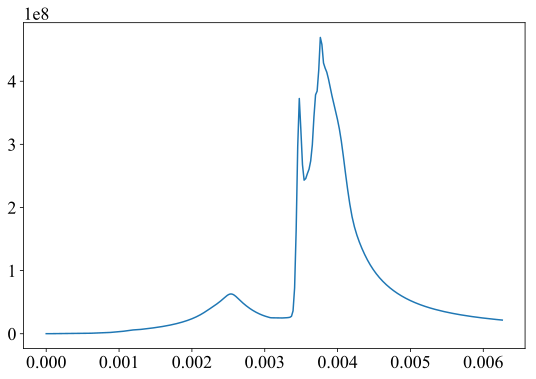

In [43]:
res3 = calc_sol(my_abcde[3])
print_res(res3)

In [45]:
def convert_layers(res):
    ts = np.array([r[0].time for r in res])
    xss = []
    pss = []
    for r in res:
        xs = np.concatenate([l.x_c for l in r])
        ps = np.concatenate([l.p for l in r])
        xss.append(xs)
        pss.append(ps)
    return np.vstack(xss), np.vstack(pss)
        
xs, ps = convert_layers(res3)

In [46]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(res3)-1,step=1, value=0))
def plotMe(ind):
    plt.plot(xs[ind], ps[ind])
    plt.plot()

interactive(children=(IntSlider(value=0, description='ind', max=190), Output()), _dom_classes=('widget-interac…

1.5208041636909911e-06 2.398646674439725
0.0034458873462895542 2.399267836278054
0.004338673530146729 2.4690188166101263
0.0046066601193473205 2.605302336614576
0.004782234996801213 2.8025242637950214
0.0049784190466509795 3.1563969395158713
0.005320049675227946 3.9742604746832146
0.006197435290866701 6.493083568369153
238102637.28821275 3185.077036066787


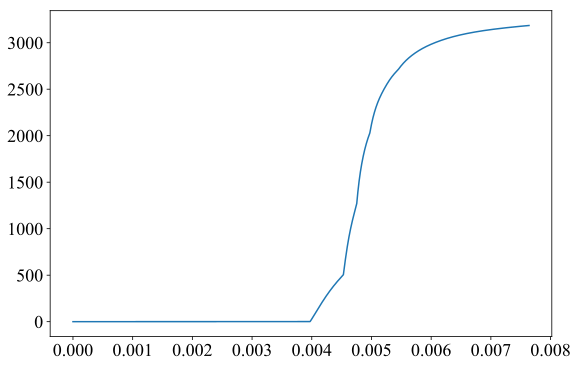

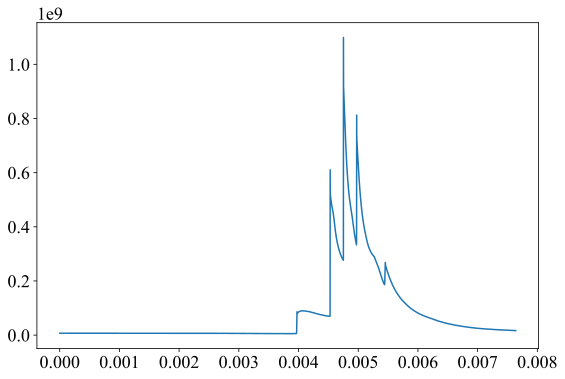

In [47]:
res4 = calc_sol(my_abcde[4])
print_res(res4)

In [48]:
xs, ps = convert_layers(res4)

In [49]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(res4)-1,step=1, value=0))
def plotMe(ind):
    plt.plot(xs[ind], ps[ind])
    plt.plot()

interactive(children=(IntSlider(value=0, description='ind', max=2281), Output()), _dom_classes=('widget-intera…

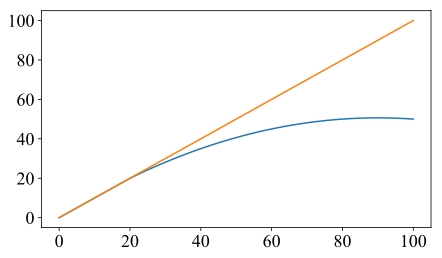

In [85]:
def my_smooth(v, wsize):
    n = len(v)
    def corr_inds(i):
        i1 = i-wsize if i-wsize > 0 else 0
        i2 = i+wsize if i+wsize < n-1 else n-1
        return i1, i2
    res = np.zeros_like(v)
    for i in range(n):
        i1, i2 = corr_inds(i)
        srez = v[i1:i2]
        res[i] = np.mean(srez)
    return res

def my_pmasht(ps, pmax):
    psmax = np.max(ps)
    koeff = pmax/psmax
    if koeff > 1:
        return ps
    res = np.zeros_like(ps)
    h = koeff
    for i in range(len(ps)):
        p = ps[i]
        k1 = 0.4
        if p < pmax * k1:
            res[i] = p
            continue
        x = (p-pmax*k1)/(psmax-k1*pmax)
        k = (h-1)*x+1
        res[i] = k*p
    return res
 
def get_V_from_I(res, ts, ps, vs, m):
    tube = res[0][0].tube
    dts = ts[1:] - ts[:-1]
    xs = np.array([r[-1].x[-1] for r in res])
    ss = tube.get_S(xs)
    i_ps = np.sum(((ps[:-1]-10E5)*dts*ss[:-1])[vs[:-1]>0])
    return i_ps / m

def plot_res(res, vmax, pmax, wsize, smooth_rounds=1):
    ts = np.array([r[-1].time for r in res])
    xs = np.array([r[-1].x[-1] for r in res])
    vs = np.array([r[-1].V[-1] for r in res])
    ps = np.array([r[-1].p[-1] for r in res])
    koeff = vmax/vs[-1]
    vs *= koeff
    ts /= koeff
    ps *= koeff
    for _ in range(smooth_rounds):
        ps = my_smooth(ps, wsize)
    ps = my_pmasht(ps, pmax)
    return ts, vs, ps, xs

x = np.linspace(0,100,100)

y = my_pmasht(x, 50)
plt.plot(x,y)
plt.plot(x,x)
plt.show()

# x = np.linspace(0,1,100)
# h = 0.1
# y = -(1-h)*x*x + 1
# plt.plot(x,y)

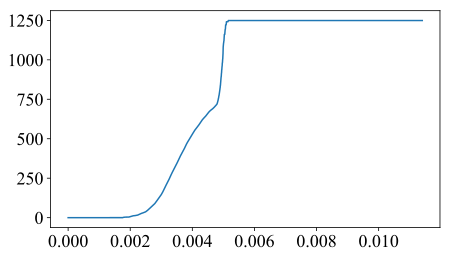

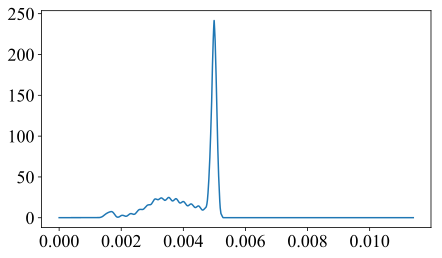

1209.8108244356551

In [86]:
ts0, vs0, ps0, xs0 = plot_res(res, 1249, 450E6, 15, 2)
plt.plot(ts0, vs0)
plt.show()
plt.plot(ts0, ps0/1E6)
plt.show()
get_V_from_I(res, ts0, ps0,vs0,0.023)

In [87]:
len(xs0)

2178

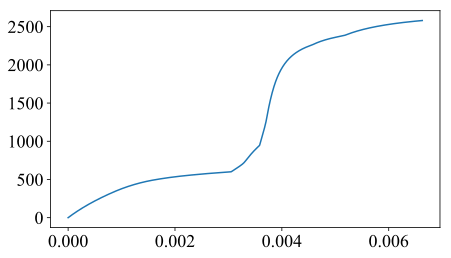

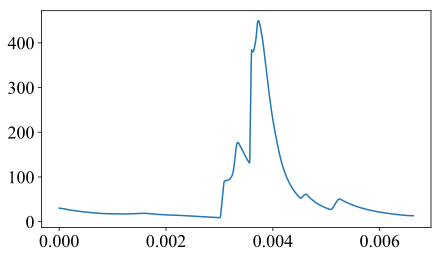

2411.0130178994386

In [88]:
ts1, vs1, ps1, xs1 = plot_res(res1, 2580, 450E6, 5)
plt.plot(ts1*1.1, vs1)
plt.show()
plt.plot(ts1*1.1, ps1/1E6)
plt.show()
get_V_from_I(res1, ts1*1.1, ps1,vs1,0.023)

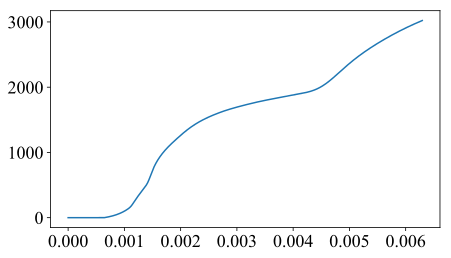

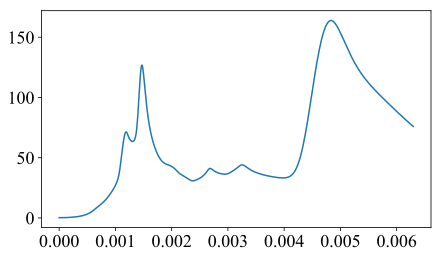

3020.287860631096

In [89]:
ts2, vs2, ps2, xs2 = plot_res(res2, 3022, 405E6, 5)
plt.plot(ts2, vs2)
plt.show()
plt.plot(ts2, ps2*1.5/1E6)
plt.show()
get_V_from_I(res2, ts2, ps2*1.5,vs2,0.023)

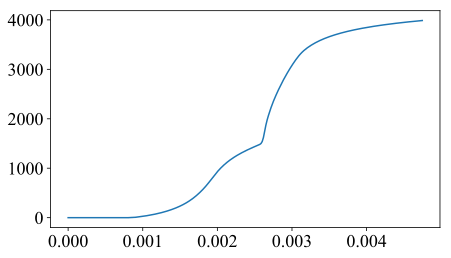

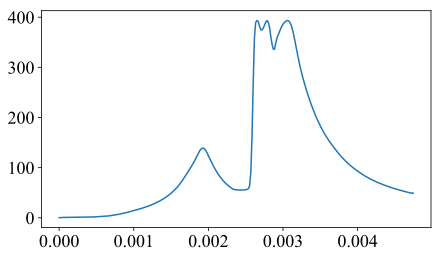

3911.0875582017106

In [90]:
ts3, vs3, ps3, xs3 = plot_res(res3, 3987, 200E6, 2)
plt.plot(ts3, vs3)
plt.show()
plt.plot(ts3, ps3*1.68/1E6)
plt.show()
get_V_from_I(res3, ts3, ps3*1.68,vs3,0.023)

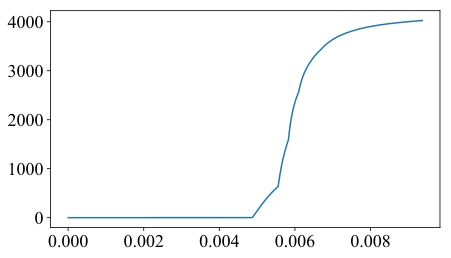

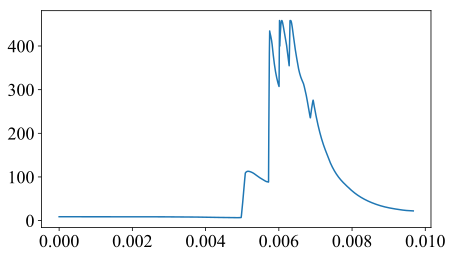

4038.775385688361

In [91]:
ts4, vs4, ps4, xs4 = plot_res(res4, 4025, 400E6, 15)
plt.plot(ts4*1.55, vs4)
plt.show()
plt.plot(ts4*1.6, ps4*1/1E6)
plt.show()
get_V_from_I(res4, ts4*1.6, ps4*1,vs4,0.023)

In [12]:
mpl.rcParams['figure.figsize'] = (7,4) 
plt.plot(xs0, vs0, label='$a$', lw=1.5, c='mediumblue')
plt.plot(xs1, vs1, label='$b$', lw=1.5, ls='--', c='black')
plt.plot(xs2, vs2, label='$c$', lw=1.5, c='r')
plt.plot(xs3, vs3, label='$d$', lw=1.5, ls='-.', c='darkorange')
plt.plot(xs4, vs4, label='$e$', lw=1.5, ls='-', c='g')

plt.figtext(0.055, 0.9, '$u_{pr}$, m/s')
plt.xlabel('$x$, m')

plt.grid()
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('u_pr(x).png', dpi=300)

NameError: name 'xs0' is not defined

In [134]:
len(vs0), len(xs0)

(2178, 2178)

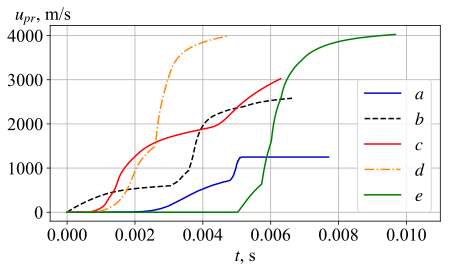

In [27]:
mpl.rcParams['figure.figsize'] = (7,4) 
lw = 1.5
plt.plot((ts0)[:-300], vs0[:-300], label='$a$', lw=lw, c='mediumblue')
plt.plot(ts1*1.1, vs1, label='$b$', lw=lw, ls='--', c='black')
plt.plot(ts2, vs2, label='$c$', lw=lw, c='r')
plt.plot(ts3, vs3, label='$d$', lw=lw, ls='-.', c='darkorange')
plt.plot(ts4*1.6, vs4, label='$e$', lw=lw, ls='-', c='g')

plt.figtext(0.055, 0.9, '$u_{pr}$, m/s')
plt.xlabel('$t$, s')

plt.xlim(-0.5e-3,11e-3)
# plt.ylim(-200,4800)
plt.grid()
plt.legend()
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('u_pr(t).png', dpi=300)
plt.savefig('4a.png', dpi=300)

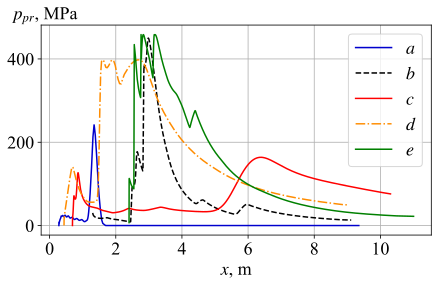

In [136]:
plt.plot(xs0, ps0/1E6, label='$a$', lw=1.5, c='mediumblue')
plt.plot(xs1, ps1/1E6, label='$b$', lw=1.5, ls='--', c='black')
plt.plot(xs2, ps2*1.5/1E6, label='$c$', lw=1.5, c='r')
plt.plot(xs3, ps3*1.70/1E6, label='$d$', lw=1.5, ls='-.', c='darkorange')
plt.plot(xs4, ps4*1/1E6, label='$e$', lw=1.5, ls='-', c='g')

plt.figtext(0.07, 0.9, '$p_{pr}$, MPa')
plt.xlabel('$x$, m')

plt.grid()
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('p_pr(x).png', dpi=300)

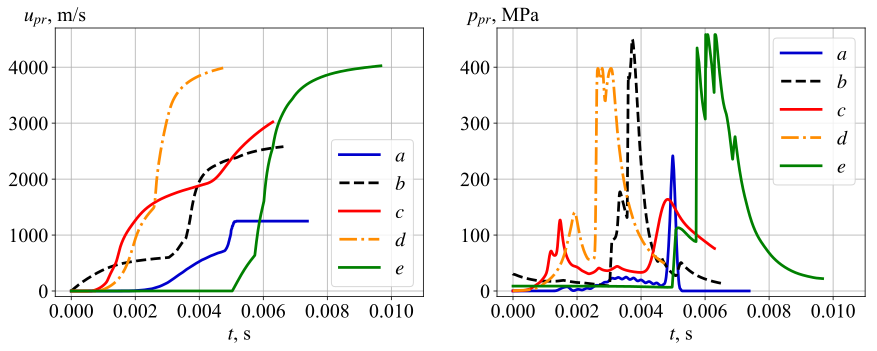

In [151]:
# plt.plot(ts0*1000, vs0, label='$a$', lw=1.5, c='mediumblue')
# plt.plot(ts1*1.1*1000, vs1, label='$b$', lw=1.5, ls='--', c='black')
# plt.plot(ts2*1000, vs2, label='$c$', lw=1.5, c='r')
# plt.plot(ts3*1000, vs3, label='$d$', lw=1.5, ls='-.', c='darkorange')
# plt.plot(ts4*1.6*1000, vs4, label='$e$', lw=1.5, ls='-', c='g')
lw=2.75
plt.subplot(121)
plt.plot((ts0)[:-330], vs0[:-330], label='$a$', lw=lw, c='mediumblue')
plt.plot(ts1*1.1, vs1, label='$b$', lw=lw, ls='--', c='black')
plt.plot(ts2, vs2, label='$c$', lw=lw, c='r')
plt.plot(ts3, vs3, label='$d$', lw=lw, ls='-.', c='darkorange')
plt.plot(ts4*1.6, vs4, label='$e$', lw=lw, ls='-', c='g')

plt.figtext(0.095, 0.9, '$u_{pr}$, m/s')
plt.xlabel('$t$, s')

plt.xlim(-0.5e-3,11e-3)
plt.ylim(-100,4700)
plt.grid()
plt.legend(loc='lower right')
plt.gcf().subplots_adjust(bottom=0.1)


plt.subplot(122)
plt.plot((ts0)[:-330], (ps0/1E6)[:-330], label='$a$', lw=lw, c='mediumblue')
plt.plot(ts1*1.1, ps1/1E6, label='$b$', lw=lw, ls='--', c='black')
plt.plot(ts2, ps2*1.5/1E6, label='$c$', lw=lw, c='r')
plt.plot(ts3, ps3*1.70/1E6, label='$d$', lw=lw, ls='-.', c='darkorange')
plt.plot(ts4*1.6, ps4*1/1E6, label='$e$', lw=lw, ls='-', c='g')

plt.figtext(0.52, 0.9, '$p_{pr}$, MPa')
plt.xlabel('$t$, s')
plt.xlim(-0.5e-3,11e-3)
plt.ylim(-10,470)
plt.grid()
plt.legend()
plt.gcf().subplots_adjust(bottom=0.1)
# plt.savefig('p_pr(t).png', dpi=300)
plt.savefig('4ab.png',bbox_inches='tight',dpi=300, format='png', pad_inches=0.1)

In [131]:
import pickle
# save_dict = {
#     'ts0': ts0,
#     'ts1': ts1,
#     'ts2':ts2,
#     'ts3':ts3,
#     'ts4':ts4,
#     'ps0':ps0,
#     'ps1':ps1,
#     'ps2':ps2,
#     'ps3':ps3,
#     'ps4':ps4,
#     'vs0':vs0,
#     'vs1':vs1,
#     'vs2':vs2,
#     'vs3':vs3,
#     'vs4':vs4
    
# }
# with open('ArticlePlotData.bin', 'wb') as f:
#     pickle.dump(save_dict, f)

In [132]:
with open('ArticlePlotData.bin', 'rb') as f:
    save_dict = pickle.load(f)

In [133]:
ts0=save_dict['ts0']
ts1=save_dict['ts1']
ts2=save_dict['ts2']
ts3=save_dict['ts3']
ts4=save_dict['ts4']
ps0=save_dict['ps0']
ps1=save_dict['ps1']
ps2=save_dict['ps2']
ps3=save_dict['ps3']
ps4=save_dict['ps4']
vs0=save_dict['vs0']
vs1=save_dict['vs1']
vs2=save_dict['vs2']
vs3=save_dict['vs3']
vs4=save_dict['vs4']


# %matplotlib inline 
# %config InlineBackend.figure_format = 'svg' 

# mpl.rcParams['figure.figsize'] = (7,4) 
# plt.rcParams["font.family"] = "Times New Roman"
# # ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams.update({'font.size': 18})
# # del mpl.font_manager.weight_dict['roman']
# mpl.font_manager._rebuild()